# Genertating sample particles using a 2D rejection algorithm #

by: Conor Davidson 22/08/2024

A sample of $N$ particles can be sampled from any continuous two dimensional function using a rejection algorithm. This algorithm is useful for generating particle distributions for particle-in-cell simulations however, it can be applied to any known function. The mathematical idea of the algorithm is outlined here: https://bookdown.org/rdpeng/advstatcomp/rejection-sampling.html. 

To illustrate the idea for one dimensional sampling, we can imagine a sqaure board with a mask that blocks out a portion of the board. If we used a Gaussian function of $x$ as an example, the mask covers the area above the Gaussian function. By throwing darts at the board, representing particles, any that hit the masked portion of the board will be rejected while any that hit the board are accepted. By repeating this process until we have $N$ accepted samples, we have generated a sample from the Gaussian function. The interesting part is that the mask can be any function we choose. The function can also be any number of dimensions although more dimensions adds more complexity and computational time.

To further boost the performance, `numpy` arrays with the advantages of vectorisation are used. I have included the non-vectorised algorithm for completeness but the `rejection_2d_vectorised` function should be used in the first instance.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
#import astropy as ap
from scipy.integrate import quad, dblquad

#plotting parameters
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 400

#1D rejection algorithm
def rejection(N, d, func, **funcparams):
    """For N samples of the distribution function func and x range d, return N length array with
    sampled x positions. **funcparams are the keyword arguments for the general function"""
    
    samples = np.zeros(N) #returned sample array
    
    for i in range(N):
        #print("Particle: %d" % i)
        x = 0.5 #initialise so while loop will run at least once
        prob = 0.0
        rsample = 1.0
        while rsample > prob:
            x = np.random.rand()*d #generate uniform float for the x value
            #print(x)
            prob = func(x, **funcparams) #probability at this x value
            #print(prob)
            rsample = np.random.rand() #sample along this line
            #if rsample is greater than max probabiliyt at f(x), reject x and start again
            
        #x is now below prob
        samples[i] = x
        
    return samples

##Create a 2D version of the rejection algorithm
def rejection_2d(N, minx, Lx, miny, Ly, func, **funcparams):
    """For N samples of the distribution function func and x range Lx and y range Ly, return N length array with
    sampled x, y positions. **funcparams are the keyword arguments for the general function"""
    
    samples = np.zeros((N,2)) #returned sample array with x,y positions
    
    #find the maximum of the func
    max_xpoints = np.linspace(minx, Lx, 1000)
    max_ypoints = np.linspace(miny, Ly, 1000)
    X,Y = np.meshgrid(max_xpoints, max_ypoints)
    z_max = np.max(func(X,Y, **funcparams))
    
    for i in range(N):
        #print("Particle: %d" % i)
        x = 0.5 #initialise so while loop will run at least once
        prob = 0.0
        rsample = 1.0
        k = 0 #iteration counter
        while rsample > prob:
            x = minx + np.random.rand()*(Lx - minx) #generate uniform float for the x value
            y = miny + np.random.rand()*(Ly - miny) #same for y value
            #print(x)
            prob = func(x, y, **funcparams) #probability at this (x,y) value
            #print(prob)
            rsample = np.random.uniform(0.0, 1.0)*z_max #compare random number to prob
            #if rsample is greater than max probabiliyt at f(x), reject (x,y) and start again
            k += 1
            if k > 10000:
                print("While loop reached %d iterations for one sample" % k)
                break
            
        #print("Particle %d created" %i)    
        #pdf(x,y) is now below prob
        samples[i] = (x,y)
        
    return samples

#A vectorised version of the 2D rejection algorithm
def rejection_2d_vectorised(N, minx, Lx, miny, Ly, func, func_max = None,**funcparams):
    """For N samples of the distribution function func and x range Lx and y range Ly, return N length array with
    sampled x, y positions. 
    
    Input parameters:
    N - int, desired number of generated samples
    minx, Lx - float, minimum and maximum values on the x axis respectively
    miny, Ly - float, ditto for the y axis
    func_max - float, predetermined function maximum, if not provided it will be approximated
    using a large function domain, default None
    func - python function, the function from which to generate the samples
    funcparams - tuple, keyword arguments used in the function
    
    
    Vectorised the process using numpy arrays"""
    
    samples = np.zeros((N,2)) #returned sample array with x,y positions
    
    #find the maximum of the func
    if func_max == None: #unknown function maximum
        max_xpoints = np.linspace(minx, Lx, 1000)
        max_ypoints = np.linspace(miny, Ly, 1000)
        X,Y = np.meshgrid(max_xpoints, max_ypoints)
        z_max = np.max(func(X,Y, **funcparams)) #this is needed for the rsample values
        print("Max is: ", z_max)
    else: #predetermined function maximum
        z_max = func_max + 1e-2 #We know the maximum density is achieved by the target density
    
    ncomplete = 0
    k = 0 #iteration counter
    max_iter = 1000
    while (ncomplete < N) and (k < max_iter): #run until N samples have been generated
        #generate random x, y positions from minx to Lx in x and miny to Ly for y
        xarray = np.random.uniform(low = minx, high = Lx, size = (N - ncomplete))
        yarray = np.random.uniform(low = miny, high = Ly, size = (N - ncomplete))
        
        #determine the probabilities at the random x.y positions                           
        probs = func(xarray, yarray, **funcparams) #probabilities at x, y positions
        rsamples = np.random.uniform(0.0, 1.0, size = np.shape(probs))*z_max #probabilities for rejection
        
        comparison_array = rsamples < probs #accept samples with 0 to z_max under prob value
        nold = ncomplete #running number of generated samples
        nnew = np.count_nonzero(comparison_array) #new generated samples, True is a count of 1
        ncomplete = np.count_nonzero(comparison_array) + nold #total number of accepted samples
        
        #index out the accepted x,y positions and save the values
        accepted_x = xarray[np.nonzero(comparison_array)]
        #print(accepted_x)
        accepted_y = yarray[np.nonzero(comparison_array)]
        #print(accepted_y)
        samples[nold:ncomplete,0] = accepted_x
        samples[nold:ncomplete,1] = accepted_y
        k += 1 #iteration counter
        
        if k == max_iter: #reached maximun number of iterations
            print("Reached the maximum number of iterations, with %d generated samples" % (ncomplete))
        
        #print("New number of generated samples is %d" % nnew)
    
    print("Total number of iterations was %d " % k)
    print("Shape of final generated sample array is ", np.shape(samples))
    return np.array(samples)
        


## Gaussian test ##

The following will show the generation of samples from some test function so that the user can see the algorithm in action. Let us start with a 2D Gaussian functions which has the form:

$$
f(x,y) = A \exp \bigg( -  \bigg( \frac{(x - x_0)^2}{2 \sigma^2_x} + \frac{(y - y_0)^2}{2 \sigma^2_y} \bigg) \bigg)
$$

where $A$ is a constant, $x_0$ is the mean along the $x$ axis, $y_0$ is the mean along the $y$ and $\sigma_{x,y}$ are the standard deviations along the $x$ and $y$ axes. We will now generate samples from this distribution

Max is:  0.006358877042975879
Total number of iterations was 98 
Shape of final generated sample array is  (20000, 2)


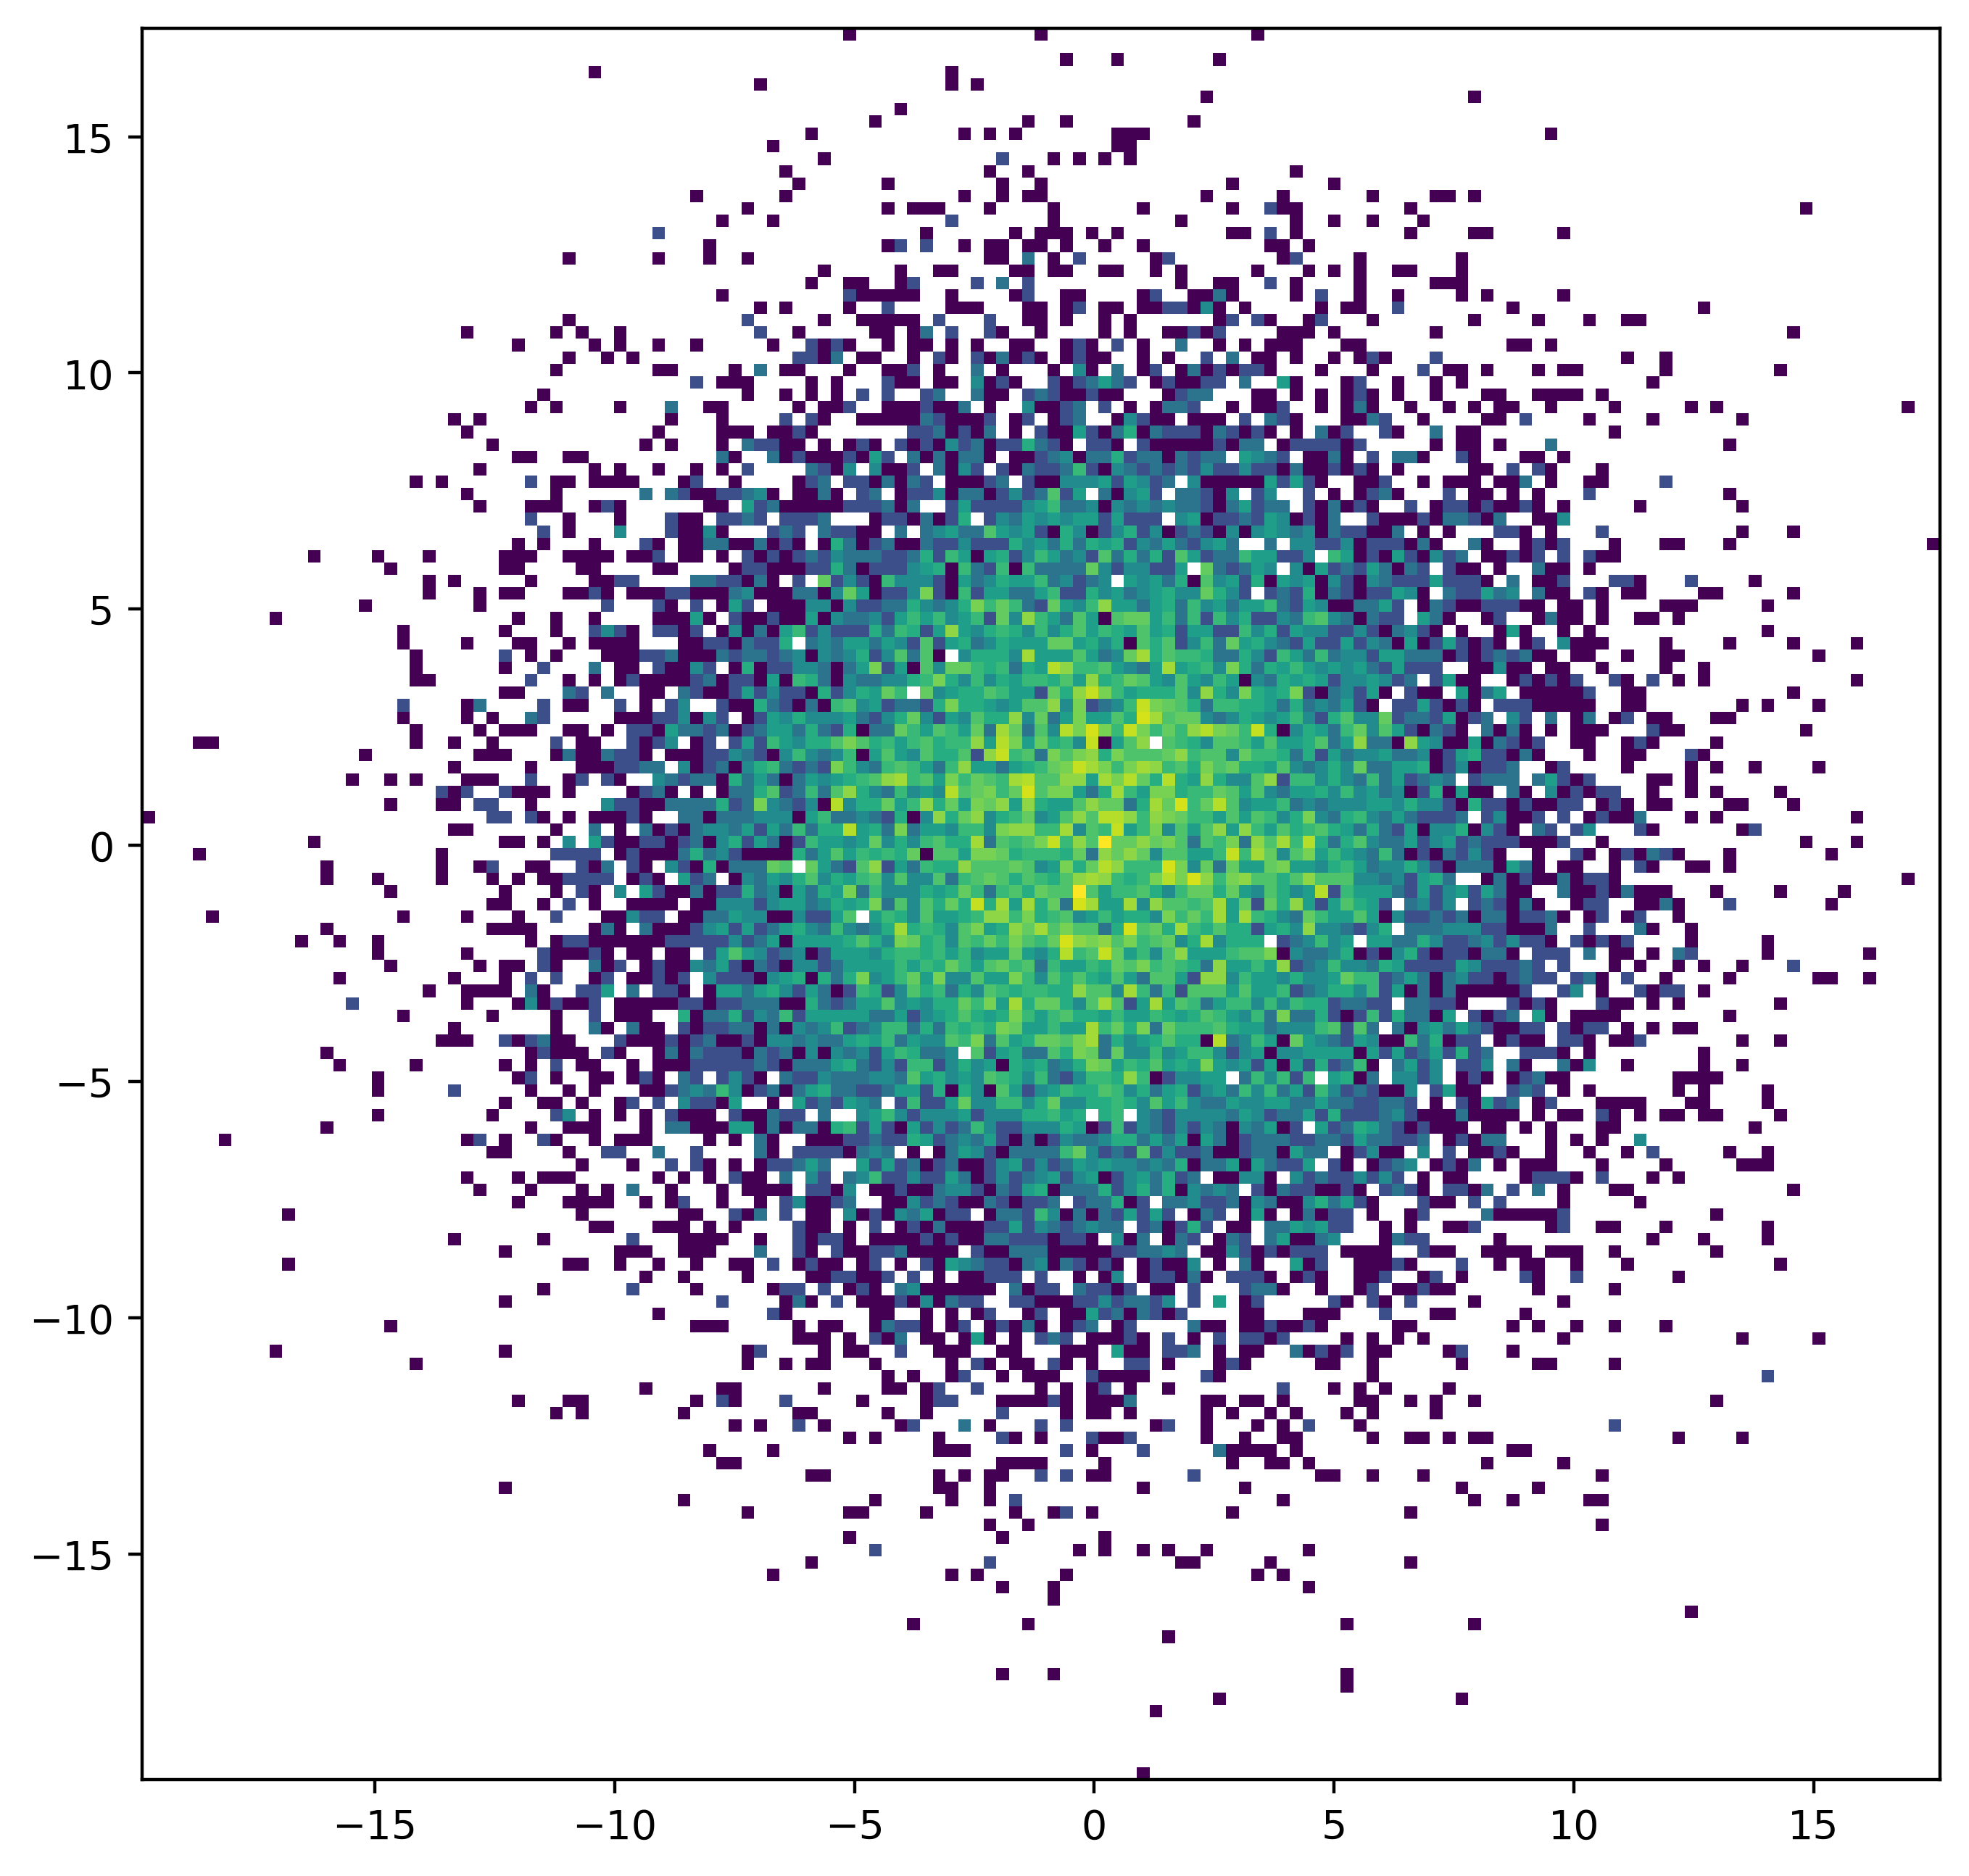

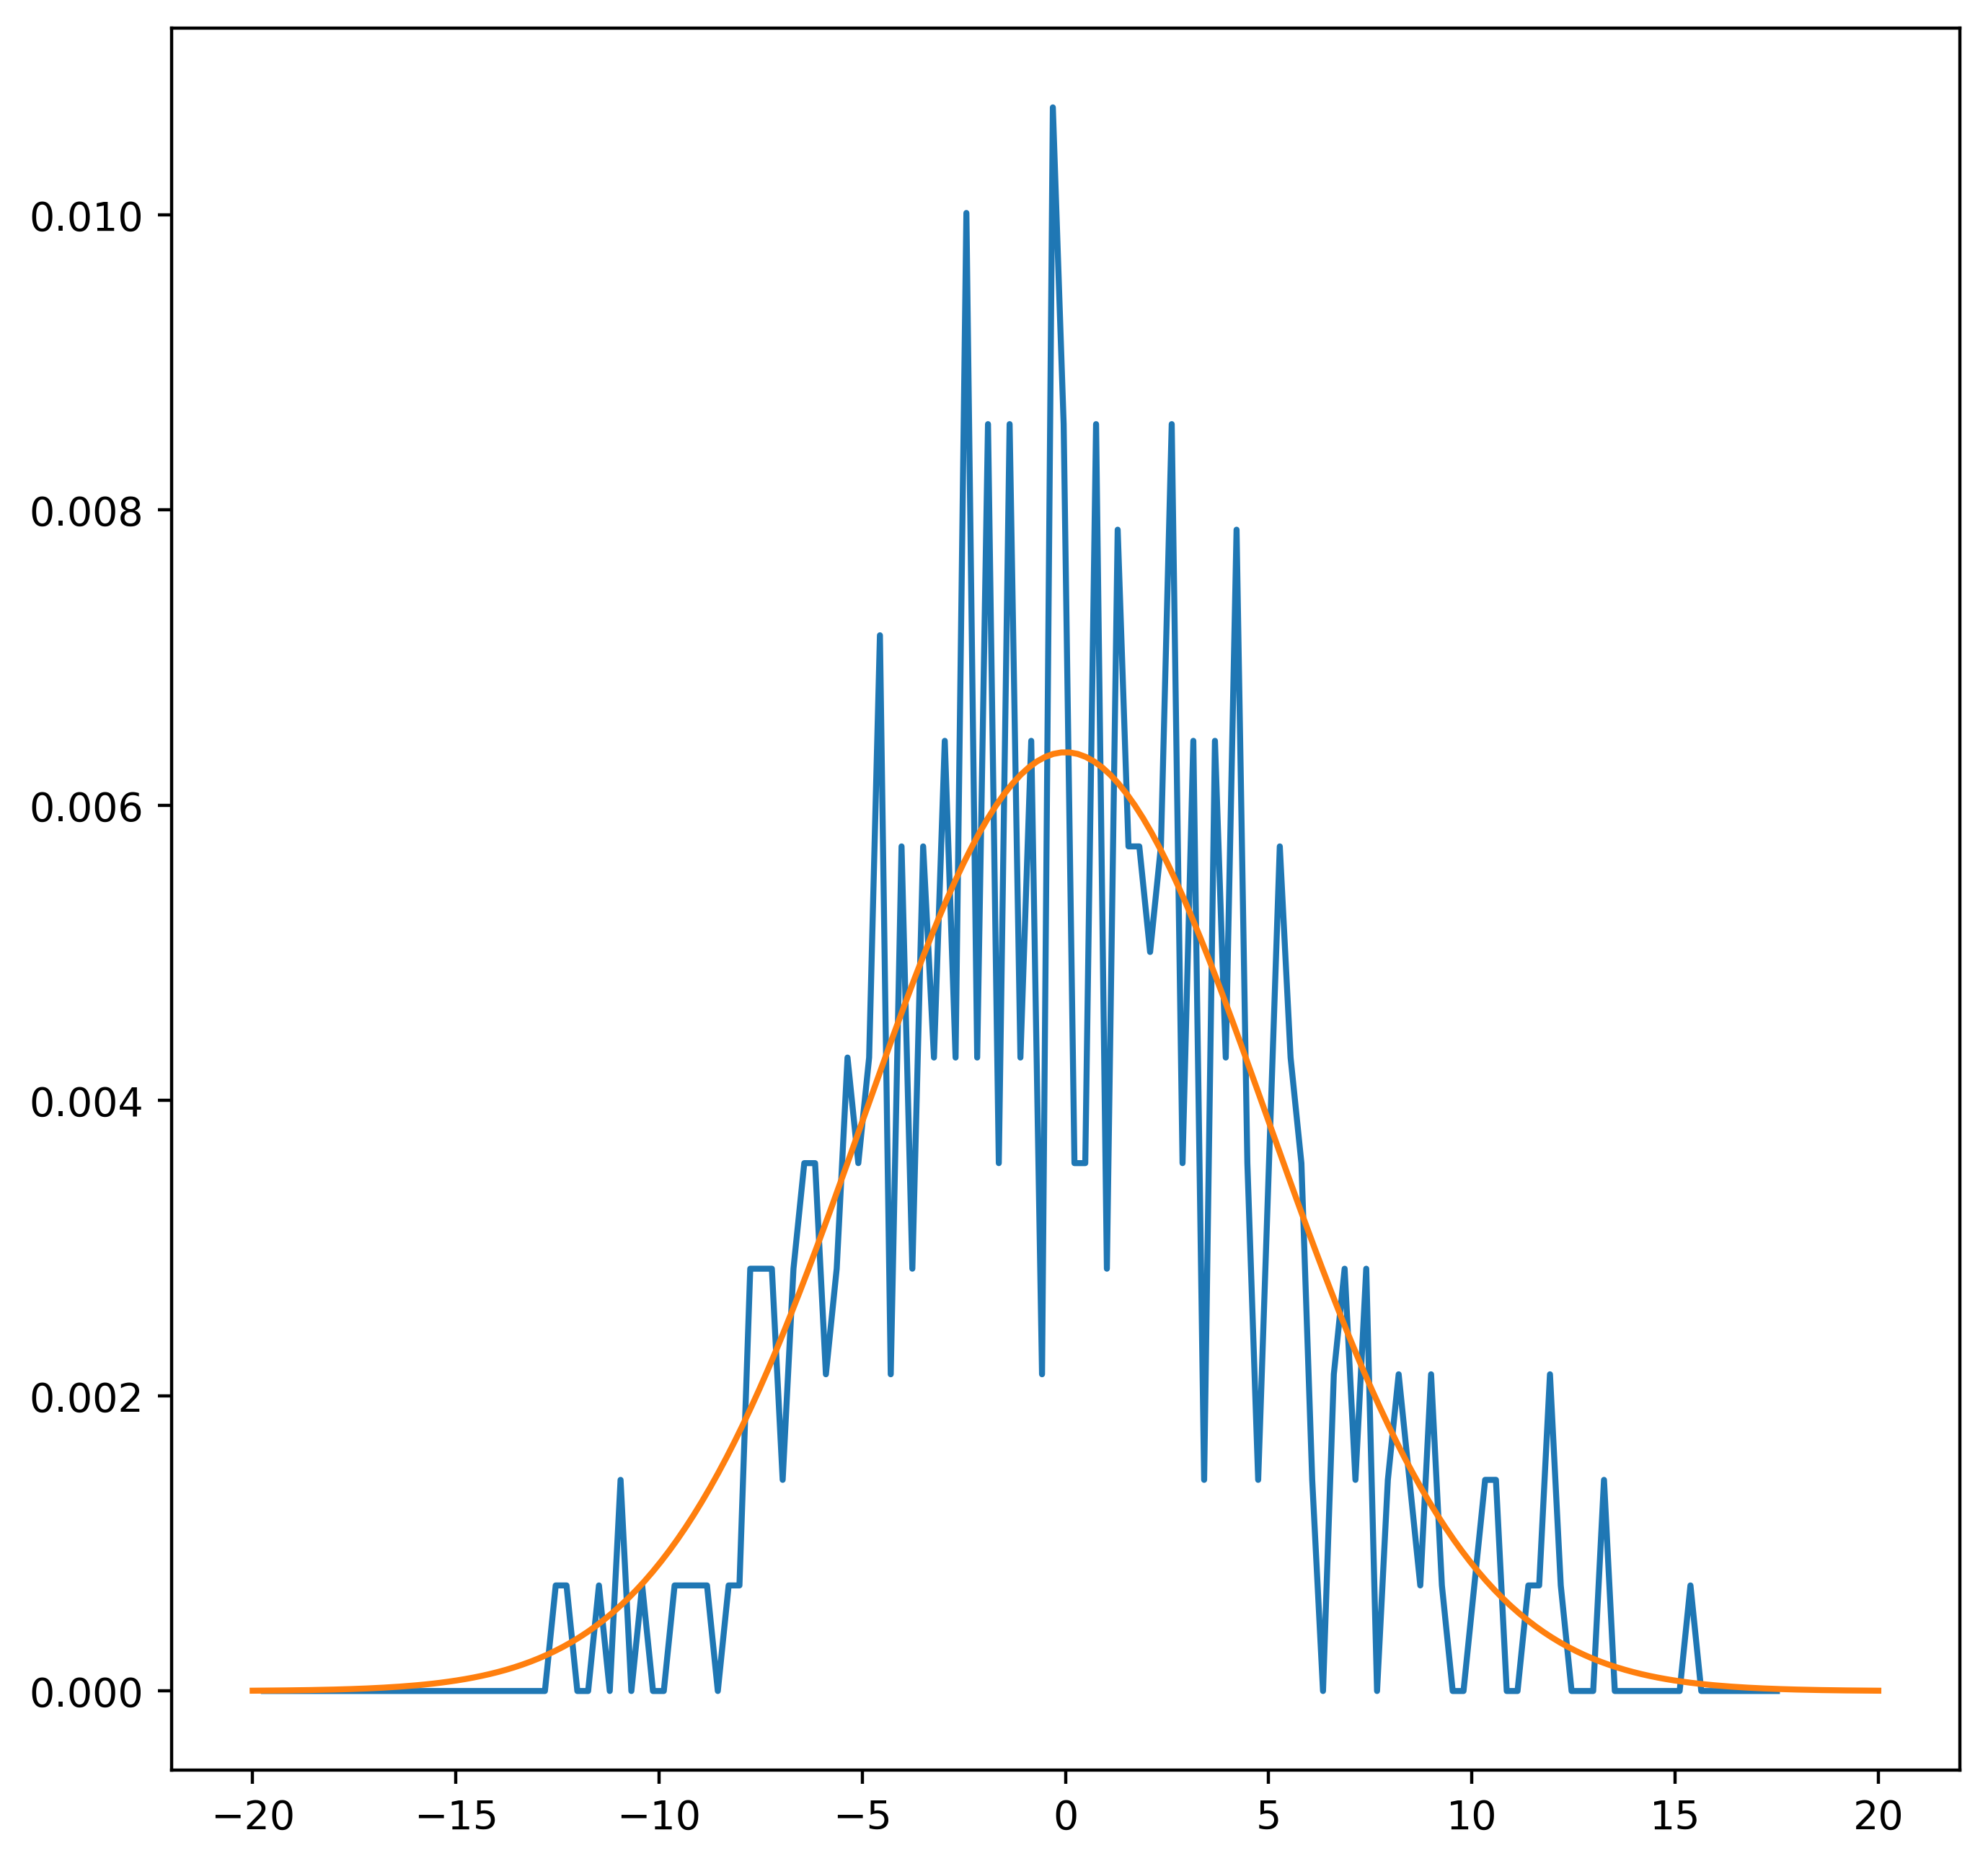

In [58]:
N = 20000 #number of particles
bins_x = int(np.sqrt(N)) #bins for histograms
bins_y = int(np.sqrt(N))
minx = -20.0
Lx = 20.0
miny = -20.0
Ly = 20.0

#simple gaussian for testing
def gaussian(x, y, **kwargs):
    """Simple 1D normalised Gaussian"""
    cst = kwargs["A"]
    xnaught = kwargs["mean_x"]
    ynaught = kwargs["mean_y"]
    sigmax = kwargs["stdev_x"]
    sigmay = kwargs["stdev_y"]
    
    value = cst*np.exp(-1.0*((x - xnaught)**2/(2*sigmax**2) + (y - ynaught)**2/(2.0*sigmay**2)))
    return value

#Generate samples using a constant that normalises the Gaussian function, this simplifies the comparison with histograms
samples = rejection_2d_vectorised(N, minx, Lx, miny, Ly, gaussian, A = 1/157.25795, mean_x = 0.0, mean_y = 0.0, stdev_x = 5.0, stdev_y = 5.0)
xpoints = samples[:,0]
ypoints = samples[:,1]

#2D histogram plot on color logarithm scale
plt.figure()
hist, edges_x, edges_y, img = plt.hist2d(xpoints, ypoints, bins= [bins_x, bins_y], density = True, norm = clr.LogNorm())

#Plot a lines along axis for comparison
plt.figure()
xplotpoints = np.linspace(minx, Lx, 200)
#convert x edges to bin centers
xcentres = (edges_x[:-1] + edges_x[1:])/2.0

#plt.hist(xpoints, bins = bins_x, density = True)
plt.plot(xcentres, hist[:,bins_y//2])
plt.plot(xplotpoints, gaussian(xplotpoints, np.zeros(len(xplotpoints)),  A =  1/157.25795, mean_x = 0.0, mean_y = 0.0, stdev_x = 5.0, stdev_y = 5.0))
plt.show()